# Taller 1

El objetivo de este taller es que se familiarice con conceptos básicos de redes neuronales y con herramientas que le permitan implementar modelos más competitivos más adelante. 



<table align='left'>
<tr>
<td><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/Hubble-Space-Telescope-Galaxy-Collection.jpg/700px-Hubble-Space-Telescope-Galaxy-Collection.jpg' width='900'/> </td>
</tr>
</table>

# Base Imports

In [1]:
from tensorflow import keras
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os

from keras.optimizers import Adam
from tensorflow.keras.layers import Dense


# Problema y Datos

Utilizaremos datos provenientes de Galaxy Zoo, un proyecto astronómico internacional en el que cientos de voluntarios no expertos participaron etiquetando imágenes de galaxias de acuerdo a diferentes patrones morfológicos. La versión que utilizaremos ha sido pre-procesada para incluir 10 clases diferentes y el objetivo es poder contar con un programa que en el futuro analice automáticamente grandes volúmenes de imágenes astronómicas para reconocer objetos de interés. 

*Se advierte que este es un problema bastante realista a diferencia de los ejemplos que hemos visto sobre MNIST, Fashion MNIST, o CIFAR, de modo que no es trivial obtener buenos rendimientos. Manténgase resiliente y recuerde que su objetivo en la experiencia es aprender conceptos y "trucos" básicos para más adelante.*



Notará que los datos han sido divididos en 3 particiones diferentes: entrenamiento (train), validación (val), y pruebas (test). Ya deberá explicar para qué se usa c/u. Por ahora note también que se ha incluido una selección "reduced_train" a utilizar en algunos experimentos en que entrenar sobre el dataset completo es lento.

# Instrucciones 

Cada una de las siguientes secciones contiene preguntas que usted deberá abordar en el video explicativo a enviar. Se evaluarán sus respuestas a cada sección (P1, P2, etc) y su nota se calculará como el promedio de todas las secciones.

Para evaluar cada parte se considerará: 

*   Completitud: Se respondió o se hizo lo pedido?
*   Correctitud: Se respondió o se hizo correctamente lo pedido?
*   Profundidad: Se demostró interés, espíritu crítico, espíritu de investigación, y estudio de las materias?
*   Claridad: Se explicó de modo claro y sintético lo realizado, destacando lo relevante sin caer en detalles superfluos?

Fuera de eso, cualquier cosa original que haga fuera de lo pedido sumará puntos.

# P1. Load & Explore

Como punto de partida debe siempre explorar los datos disponibles, determinando de qué cosa se trata, cuántas clases existen, con cuántos cuenta para entrenar o evaluar por c/clase, etc.

* Averigue qué hace la clase tf.keras.utils.image_dataset_from_directory y porqué es conveniente utilizarla para manejar datasets de imágenes en vez de cargar cada una de ellas manualmente.

La clase se encarga de convertir un conjunto de datos almacenados en carpetas, en un objeto de clase tf.data.Dataset. Es conveniente usarla, ya que permite configurar ciertos parámetros de los datasets (como los labels, batch size, resolución de las imágenes, modo de color, etc...) de manera simple.

In [2]:
BATCH_SIZE = 32
RES_ESPACIAL = 64
TASA = 0.1
EPOCAS = 10
PATH = "galaxies_INF395"
NUM_CLASSES = 10
CHANNELS = 3
N_VISUAL_FEATURES = 128

def asignar_parametros(batch_size = 32, res_espacial = 64, epocas = 10, tasa = 0.1):
  global BATCH_SIZE, RES_ESPACIAL, EPOCAS, TASA
  BATCH_SIZE = batch_size
  RES_ESPACIAL = res_espacial
  EPOCAS = epocas
  TASA = tasa

label_list = []
for class_name in os.listdir(PATH + "/train/"):
  label_list.append(class_name)
label_list.sort()#lexicograficamente

idx2classname = {}
for idx, class_name in enumerate(label_list):
  idx2classname[idx] = class_name

print(idx2classname[0])

def load_data(path,batch_size,res=RES_ESPACIAL):
  return tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(res,res),
    shuffle=True)

train_data = load_data(PATH + "/train", batch_size=BATCH_SIZE, res=RES_ESPACIAL)
val_data = load_data(PATH + "/val", batch_size=BATCH_SIZE, res=RES_ESPACIAL)
test_data = load_data(PATH + "/test",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

Disk_Edge-on_Boxy_Bulge
Found 10636 files belonging to 10 classes.
Found 3542 files belonging to 10 classes.
Found 3558 files belonging to 10 classes.


* Determine de cuántos datos de entrenamiento, validación, y pruebas dispone, explicando el rol de c/u de estas particiones. Grafique además el número de datos por clase en cada partición. ¿Nota alguna anomalía que pueda afectar el entrenamiento?

Entrenamiento: 10636 datos, Validación: 3542 datos y Pruebas: 3558 datos.

El rol del primero es servir como input para ajustar los parámetros entrenables de la red mediante el algoritmo de backpropagation. El rol del de validación es ser un conjunto de datos que "el modelo no ha visto", que sirve para evaluar si el modelo creado es capaz de generalizar bien (busca prevenir overfitting); se usa como una forma de optimizar los hiperparámetros del modelo. El de pruebas se usa una vez que el modelo ya ha sido terminado, como una forma de verificar si este es capaz de realizar predicciones con un alto nivel de precisión.

La principal anomalía observable es la alta heterogeneidad de los datos de entrenamiento - hay clases que poseen una cantidad muy baja cantidad de datos en comparación con otras. A la hora de categorizar imágenes que pertenezcan a estas clases, el modelo puede ser menos preciso.


In [4]:
def count_by_class(dataset):
  labels = []
  for (image,label) in dataset:
    labels.append(label.numpy())
  labels_array=np.vstack(labels)
  labels_array=np.argmax(labels_array,axis=1)
  return np.unique(labels_array, return_counts=True)

unique, counts = count_by_class(train_data)

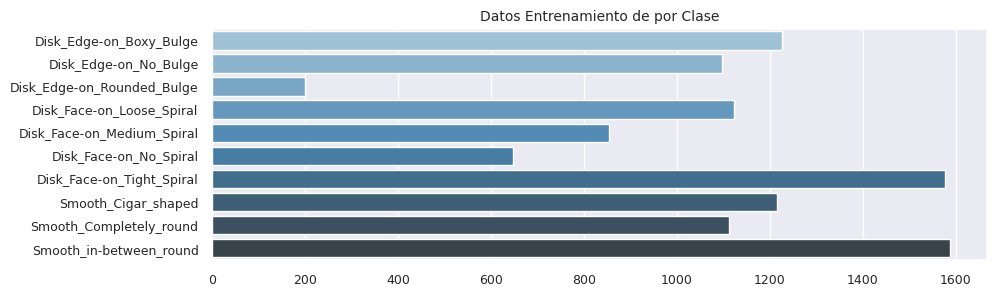

In [5]:
fig, ax = plt.subplots(figsize=(10,3),nrows=1)
b = sns.barplot(y=[idx2classname[i] for i in unique], x=counts,ax=ax,palette="Blues_d")#color='m'
b.tick_params(labelsize=9)
ax.set_title('Datos Entrenamiento de por Clase',fontsize=10)
plt.xticks(rotation=0)
plt.show()

* Determine si las imágenes son a color o en blanco y negro, explorando el número de canales de las mismas. Visualice 10 imágenes aleatorias y comente la forma de las clases de galaxias observadas.

Las imágenes en el dataset de entrenamiento poseen 3 canales, lo que indica que estas son a color (rgb).

La clase a la que pertenecen las galaxias estan definidas a grandes rasgos según la característica más distintiva que posean: espirales, bulge, forma de cigarro o forma redonda. Además, la perspectiva también define a qué clase pertenecen: si son "face-on" (están vistas desde al lado) es más fácil apreciar las carácterísticas de los espirales que la del bulbo central, por lo que se tienden a clasificar según sus espirales, mientras que si son "edge-on" se pueden apreciar de mejor forma las carácteristicas del centro de la galaxia, por lo que se clasigican según si este es redondeado, "boxy" (cuadrado) o sin un centro marcado.

In [7]:
print(train_data.element_spec[0].shape)

(None, 64, 64, 3)


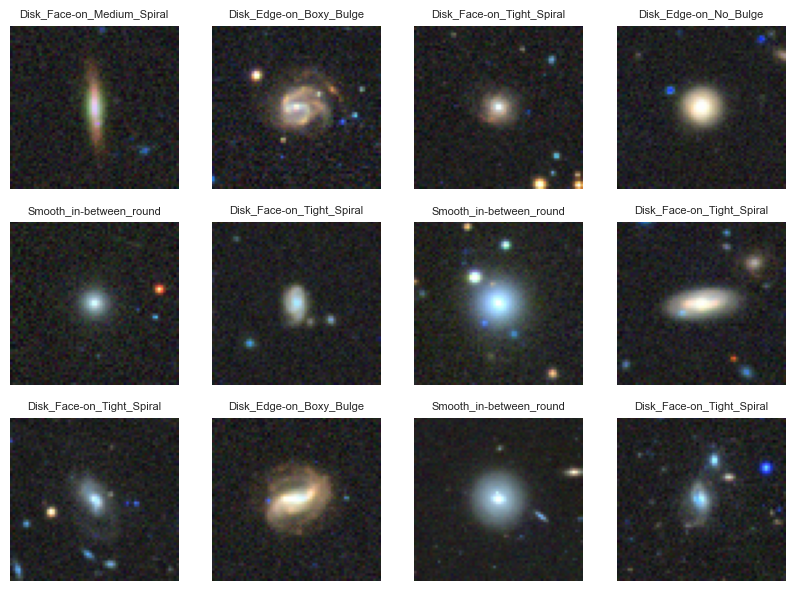

In [109]:
showme = 10
size = 10
counter = 0
fig = plt.figure('Ejemplos', figsize=[size,size*10/4])
for image, label in train_data.unbatch():
  class_name = idx2classname[np.argmax(label.numpy())]
  im = image.numpy()/255.0
  fig.add_subplot(10, 4, counter+1) 
  plt.imshow(im,aspect='auto')
  plt.grid(None) 
  plt.axis('off')
  plt.title(class_name,fontsize=8) 
  if counter>showme:
    break
  counter+=1
plt.show()

# P2. Modelo Base

El objetivo de esta sección es que aprenda a definir una red y a entrenarla diagnósticando el resultado con las herramientas adecuadas. Por el lado más práctico, debe familiarizarse con la API funcional y acostumbrarse a entrenar sin generar arreglos explícitos de datos que podrían no caber en memoria. 

* *Escale los valores de pixel correspondientes a las imágenes diviendo por 255 y comente sobre la necesidad o conveniencia de este pre-procesamiento. Convierta además, las imágenes bidimensionales en vectores y comentesobre la necesidad o conveniencia de este paso.*

Pre-procesamiento: Se dividen los valores de cada pixel por 255, de manera que todos los valores de entrada tengan una magnitud entre 0 y 1. Esto se hace para evitar que la preactivación de las neuronas crezca demasiado, saturando la función de activación de estas, y haciendo difícil que estas puedan cambiar durante el proceso de entrenamiento de la red.

Conversión en vector (flattening): Se hace porque de esta manera, se pueden realizar operaciones de algebra lineal (multiplicaciones matriz-vector) para las que existen algoritmos altamente optimizados.

In [3]:
def preprocess(x,y):
  normalization_layer = tf.keras.layers.Rescaling(1./255)
  return tf.reshape(normalization_layer(x),(-1,RES_ESPACIAL*RES_ESPACIAL*CHANNELS)),y

train_data_preprocessed = train_data.map(preprocess)
val_data_preprocessed = val_data.map(preprocess)

* *Defina un modelo completamente denso para clasificar las imágenes. Incluya para comenzar una sola capa oculta con 256 unidades ReLU. Asegúrese de incluir el número apropiado de neuronas de entrada y neuronas salida. Justifique la elección de la función de activación de la capa de salida, explicando qué cosa exactamente predecirá su modelo una vez entrenado y cómo se decidirá cuál es la clase correcta de una futura galaxia.*

La función de activación para la capa de salida es softmax, que asegura que la suma de los valores de las neuronas de salida sea igual a 1, obteniéndose así una función de densidad de probabilidad. Las predicciones entregadas por el modelo corresponden a probabilidades de que una imagen pertenezca a cada una de las clases en el conjunto de clases especificado; aquella que tenga la probabilidad más alta será la clase predicha.

In [4]:
NUM_PIXELS = RES_ESPACIAL*RES_ESPACIAL*CHANNELS
NUM_NEURONS = 256

asignar_parametros()

input = keras.Input(shape=(NUM_PIXELS))
hidden = tf.keras.layers.Dense(NUM_NEURONS, activation='relu')(input) 
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden)
model_base = tf.keras.Model(inputs=input, outputs=outputs) 
model_base.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12288)]           0         
                                                                 
 dense (Dense)               (None, 256)               3145984   
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 3,148,554
Trainable params: 3,148,554
Non-trainable params: 0
_________________________________________________________________


* *¿Cuántos parámetros entrenables tiene su modelo?*

$64 \cdot 64 \cdot 3 = 12.288\\$
$12.288 \cdot 256 + 256 = 3.145.984\\$
$256 \cdot 10 + 10 = 2.570\\$
$\Rightarrow 3.148.554$

* *Entrene ahora su modelo por E=10 épocas de entrenamiento, monitoreando el resultado después de cada época en el conjunto de entrenamiento y validación. Utilice el batch size por defecto de tamaño BATCH_SIZE, definido en P1.*

In [6]:
from keras.optimizers import Adam

optimizer = Adam()
model_base.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = model_base.fit(train_data_preprocessed, epochs=10, validation_data=val_data_preprocessed)

Epoch 1/10
333/333 [==============================] - 13s 38ms/step - loss: 1.6996 - accuracy: 0.3655 - val_loss: 1.7978 - val_accuracy: 0.3360
Epoch 2/10
333/333 [==============================] - 13s 37ms/step - loss: 1.6526 - accuracy: 0.3893 - val_loss: 1.7672 - val_accuracy: 0.3399
Epoch 3/10
333/333 [==============================] - 12s 35ms/step - loss: 1.6260 - accuracy: 0.4012 - val_loss: 1.7276 - val_accuracy: 0.3425
Epoch 4/10
333/333 [==============================] - 12s 35ms/step - loss: 1.6029 - accuracy: 0.4082 - val_loss: 1.7683 - val_accuracy: 0.3411
Epoch 5/10
333/333 [==============================] - 13s 38ms/step - loss: 1.5659 - accuracy: 0.4248 - val_loss: 1.7189 - val_accuracy: 0.3588
Epoch 6/10
333/333 [==============================] - 12s 36ms/step - loss: 1.5308 - accuracy: 0.4407 - val_loss: 1.6847 - val_accuracy: 0.3698
Epoch 7/10
333/333 [==============================] - 12s 36ms/step - loss: 1.4895 - accuracy: 0.4539 - val_loss: 1.7099 - val_accuracy:

In [7]:
new_history = model_base.fit(train_data_preprocessed, epochs=1, validation_data=val_data_preprocessed)

333/333 [==============================] - 13s 39ms/step - loss: 1.3366 - accuracy: 0.5156 - val_loss: 1.7671 - val_accuracy: 0.3704


* *Entrene el modelo por 1 época más desde el estado en el que quedó anteriormente. ¿Se hace el entrenamiento desde 0 o desde donde había quedado?*

Desde donde había quedado. Para iniciar desde cero, se requiere redefinir el modelo y su arquitectura.

* *Grafique la curva de aprendizaje sobre los datos de entrenamiento y compárela con la curva de aprendizaje sobre los datos de validación. ¿Observa algún problema? ¿Está generalizando correctamente su modelo?*

Con 10 épocas, se puede observar que la precisión del modelo, tanto para los datos de entrenamiento como los datos de validación, tiende a aumentar - lo cual es un indicador de que el modelo está siendo eficaz en generalizar.

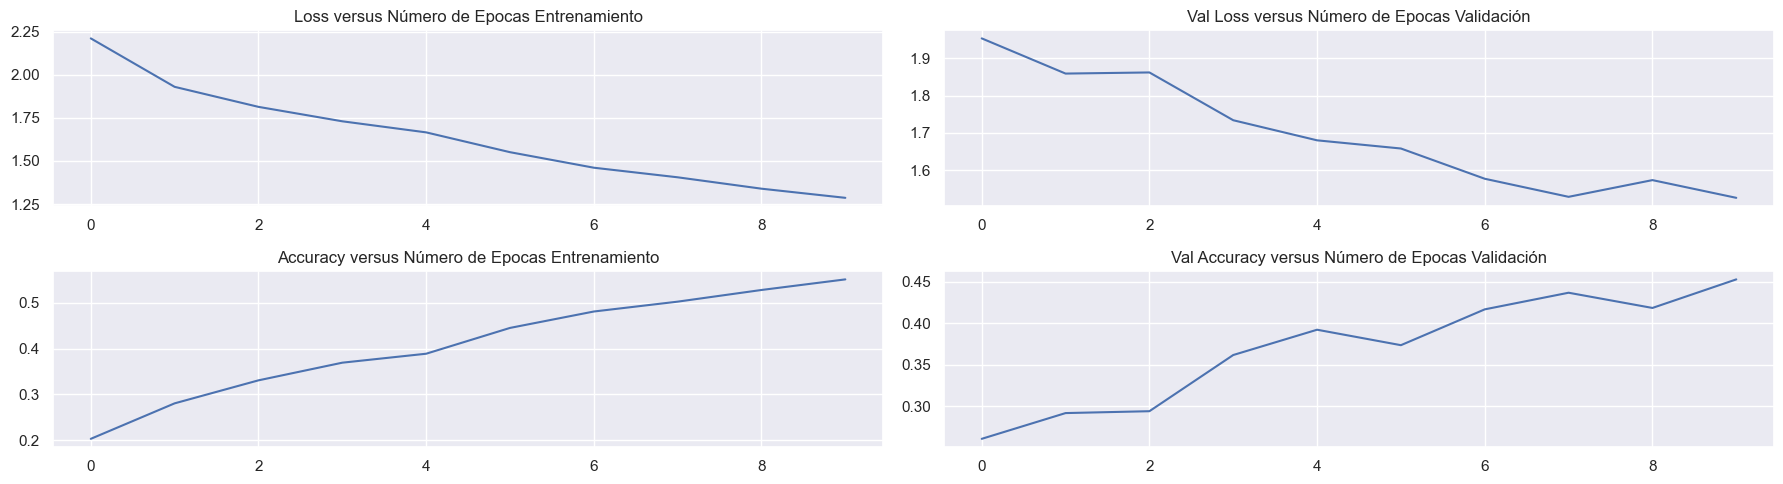

In [117]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(2, 2, figsize=(18,5))
axis[0,0].plot(history.history['loss'], label='train loss')
axis[0,1].plot(history.history['val_loss'], label='val loss')
axis[1,0].plot(history.history['accuracy'], label='train acc')
axis[1,1].plot(history.history['val_accuracy'], label='val acc')
axis[0,0].set_title("Loss versus Número de Epocas Entrenamiento")
axis[0,1].set_title("Val Loss versus Número de Epocas Validación")
axis[1,0].set_title("Accuracy versus Número de Epocas Entrenamiento")
axis[1,1].set_title("Val Accuracy versus Número de Epocas Validación")
plt.tight_layout()
plt.show()

* *Evalúe el modelo sobre el conjunto de pruebas. ¿Anticipa el error de entrenamiento final el desempeño obtenido sobre el conjunto de pruebas? ¿Anticipa el error de validación final el desempeño obtenido sobre el conjunto de pruebas? Concluya.*

El error sobre el conjunto de entrenamiento tiende a ser menor que el error sobre el conjunto de pruebas, lo cual es esperable, dado que es precisamente con estos datos con los que se adaptan los parámetros del modelo.

Por otro lado, el error de validación es un buen predictor del error sobre el conjunto de pruebas, lo que también es previsible considerando que los datos de validación no son utilizados para el entrenamiento y son utilizados sólo para el ajuste de hiperparámetros del modelo.

In [8]:
def get_accuracy(model,dataset):
  return model.evaluate(dataset,verbose=0)[1]

test_data_preprocessed = test_data.map(preprocess)
print("Accuracy Entrenamiento:", get_accuracy(model_base,train_data_preprocessed))
print("Accuracy Validación:", get_accuracy(model_base,val_data_preprocessed))
print("Accuracy Pruebas:", get_accuracy(model_base,test_data_preprocessed))

Accuracy Entrenamiento: 0.541274905204773
Accuracy Validación: 0.3704122006893158
Accuracy Pruebas: 0.37324339151382446


* *¿Es parejo el rendimiento del modelo entre las diferentes clases? ¿Qué clases se confunden más entre sí?*

No es parejo el rendimiento, existe una gran diferencia entre la precision de las distintas clases, que van desde 10% hasta 75%. No es posible, a partir de los datos, concluir cuáles son las clases que más se confunden entre sí.

Para ver qué clases se confunden más entre sí, se utiliza la matriz de confusión que muestra la proporción de predicciones realizadas para cada clase. Entonces, se puede observar, por ejemplo, que la clase "Disk_Edge-on_Boxy_Bulge" tiende a ser confundida con la clase "Disk_Edge-on_no_Bulge" y la clase "Disk_Face-on_Tight_Spiral". 

También, la clase "Disk_Edge-on_Rounded_Bulge" tiende a ser confundida con la clase "Disk_Face-on_Tight_Spiral" y la clase "Smooth_Cigar_shaped". 

Por otro lado, la clase "Disk_Face-on_No_Spiral" tiende a ser confundida con la clase "Disk_Face-on_Tight_Spiral".

Por último, la clase "Smooth_Completely_round" se confunde muchas otras clases.

In [9]:
from sklearn.metrics import classification_report
import numpy as np

def get_report(model,dataset):
  y_pred = []
  y_true = []
  for image_batch, label_batch in dataset:
    y_true.append(tf.argmax(label_batch,axis=-1))
    preds = model.predict(image_batch,verbose=0)
    y_pred.append(np.argmax(preds,axis=-1))
  correct_labels = tf.concat([item for item in y_true], axis=0)
  predicted_labels = tf.concat([item for item in y_pred], axis=0)
  cf = classification_report(correct_labels, predicted_labels, target_names=label_list)
  return cf

print("Classification Report Entrenamiento")
print(get_report(model_base, train_data_preprocessed))
print("Classification Report Validación")
print(get_report(model_base,val_data_preprocessed))
print("Classification Report Pruebas")
print(get_report(model_base,test_data_preprocessed))

Classification Report Entrenamiento
                            precision    recall  f1-score   support

   Disk_Edge-on_Boxy_Bulge       0.57      0.44      0.50      1225
     Disk_Edge-on_No_Bulge       0.53      0.71      0.61      1097
Disk_Edge-on_Rounded_Bulge       0.00      0.00      0.00       200
 Disk_Face-on_Loose_Spiral       0.53      0.70      0.60      1123
Disk_Face-on_Medium_Spiral       0.80      0.75      0.77       853
    Disk_Face-on_No_Spiral       0.78      0.17      0.27       648
 Disk_Face-on_Tight_Spiral       0.64      0.45      0.53      1576
       Smooth_Cigar_shaped       0.48      0.77      0.59      1216
   Smooth_Completely_round       0.66      0.28      0.39      1111
   Smooth_in-between_round       0.42      0.59      0.49      1587

                  accuracy                           0.54     10636
                 macro avg       0.54      0.49      0.48     10636
              weighted avg       0.57      0.54      0.52     10636

Classific

c:\Users\joaquin.deferrari\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\joaquin.deferrari\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\joaquin.deferrari\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

                            precision    recall  f1-score   support

   Disk_Edge-on_Boxy_Bulge       0.33      0.23      0.27       408
     Disk_Edge-on_No_Bulge       0.40      0.54      0.46       365
Disk_Edge-on_Rounded_Bulge       0.00      0.00      0.00        66
 Disk_Face-on_Loose_Spiral       0.35      0.47      0.40       374
Disk_Face-on_Medium_Spiral       0.63      0.50      0.56       284
    Disk_Face-on_No_Spiral       0.40      0.03      0.05       216
 Disk_Face-on_Tight_Spiral       0.46      0.35      0.40       525
       Smooth_Cigar_shaped       0.35      0.55      0.42       405
   Smooth_Completely_round       0.44      0.19      0.27       370
   Smooth_in-between_round       0.27      0.41      0.33       529

                  accuracy                           0.37      3542
                 macro avg       0.36      0.33      0.32      3542
              weighted avg       0.38      0.37      0.35      3542

Classification Report Pruebas
               

c:\Users\joaquin.deferrari\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\joaquin.deferrari\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\joaquin.deferrari\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

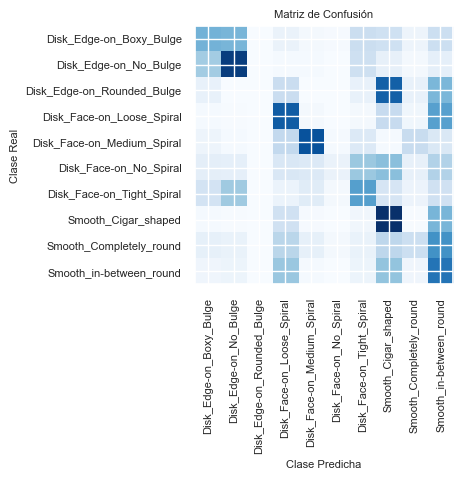

In [13]:
# Use sklearn utility to calculate the confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                            normalize=True,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
        plt.imshow(cm, interpolation='none', cmap=cmap, aspect='equal')
        plt.title(title,fontsize=8)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90, fontsize=8)
        plt.yticks(tick_marks, classes, fontsize=8)
        plt.tight_layout()
        plt.ylabel('Clase Real',fontsize=8)
        plt.xlabel('Clase Predicha',fontsize=8)
        plt.show()

def get_confusion_matrix(model,dataset):
    y_pred = []
    y_true = []
    for image_batch, label_batch in dataset:
        y_true.append(tf.argmax(label_batch,axis=-1))
        preds = model.predict(image_batch,verbose=0)
        y_pred.append(np.argmax(preds,axis=-1))
    correct_labels = tf.concat([item for item in y_true], axis=0)
    predicted_labels = tf.concat([item for item in y_pred], axis=0)
    cf = confusion_matrix(correct_labels, predicted_labels)
    return cf

cf = get_confusion_matrix(model_base,test_data_preprocessed)
plot_confusion_matrix(cf, label_list, title='Matriz de Confusión')

# P3. Más Neuronas 

El objetivo de esta sección es que aprenda a controlar el número de neuronas en la red y entender sus posibles efectos.

* *¿Da lo mismo utilizar 128 neuronas en la capa oculta respecto de usar 16 o 512? ¿Qué se espera observar si hace estos cambios? Para verificarlo, entrene su modelo base con un número creciente de neuronas. Para esto no demore excesivamente, utilice el conjunto de entrenamiento pequeño incluido dentro de la carpeta de datos (reduced_train)*. 

Se esperaría que utilizar un mayor número de neuronas se traduzca en una mejora en la precisión para datos de validación y testing, hasta un cierto número a partir del cuál aumentar la cantidad de neuronas no genera una diferencia significativa en la precisión.

In [149]:
asignar_parametros(tasa=0.08)
train_data = load_data("galaxies_INF395/reduced_train/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
val_data = load_data("galaxies_INF395/val/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
test_data = load_data("galaxies_INF395/test/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
train_data_preprocessed = train_data.map(preprocess)
val_data_preprocessed = val_data.map(preprocess)
test_data_preprocessed = test_data.map(preprocess)

Found 536 files belonging to 10 classes.
Found 3542 files belonging to 10 classes.
Found 3558 files belonging to 10 classes.


Para este experimento, utilizaremos un "truco", usualmente muy útil, que consiste en detener el entrenamiento cuando no se observen mejoras por un determinado periodo de tiempo (paciencia). De este modo, podremos fijar un número relativamente grande de épocas (E=200) que aprovecharán probablemente los modelos más "grandes".

* *Verifique que los modelos más "pequeños" requieren menor optimización para alcanzar su punto de saturación sobre los datos de entrenamiento respecto de los modelos "grandes"* 

Si entendemos por "menor optimización" que los modelos más pequeños alcanzan a mejorar menos su precisión inicial (el delta precisión final-precisión inicial es menor), entonces inicialmente sí se observa que modelos pequeños alcanzan a mejorar muy poco antes de saturarse y no poder mejorar más. Sin embargo, en modelos más grandes pareciera que no hay tanta diferencia entre cuánto alcanzan a mejorar antes de saturarse.

In [ ]:
from keras.callbacks import EarlyStopping
import time

mc =  EarlyStopping(monitor='accuracy',min_delta=0,patience=10,restore_best_weights=True)

NUM_PIXELS = RES_ESPACIAL*RES_ESPACIAL*CHANNELS


list_nneurons = [2, 16, 32, 64, 128, 256, 512]
train_accuracies = []
val_accuracies = []

for nneurons in list_nneurons:
  input = keras.Input(shape=(NUM_PIXELS))
  hidden_temp = Dense(nneurons, activation='relu')(input)  
  outputs_temp = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden_temp)
  model_temp = tf.keras.Model(inputs=input, outputs=outputs_temp) 
  model_temp.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
  start = time.time()
  history_temp = model_temp.fit(train_data_preprocessed, validation_data=val_data_preprocessed, epochs=200, callbacks=[mc], verbose=0)
  end = time.time()
  print("N° Neuronas", nneurons, "tiempo entrenamiento:", end-start, "numero de epocas:", len(history_temp.history['loss']))
  val_accuracies.append(history_temp.history['val_accuracy'])


0.14822134375572205
0.14822134375572205
0.12281197309494019
0.16487860679626465
0.1420101672410965
0.08243930339813232
0.1287408173084259


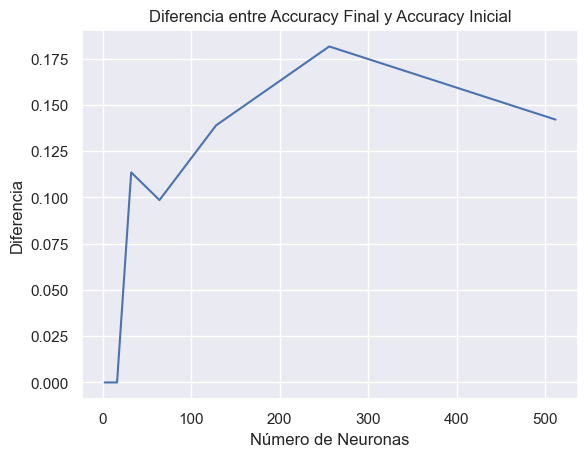

In [160]:
deltas = []
for acurracy_list in val_accuracies:
  print(acurracy_list[0])
  deltas.append(acurracy_list[-1]-acurracy_list[0])

plt.plot(list_nneurons, deltas)
plt.title("Diferencia entre Accuracy Final y Accuracy Inicial")
plt.xlabel("Número de Neuronas")
plt.ylabel("Diferencia")
plt.show()

* *¿Mejora la capacidad predictiva del modelo a medida que se aumenta el número de neuronas en la capa oculta? ¿Aumenta la cantidad de parámetros entrenables?*

Mejora hasta aproximadamente 32 neuronas, punto en el cual la precisión sobre el dataset de entrenamiento llega a 100 y la precisión sobre el dataset de validación deja de mejorar.

La cantidad de parámetros entrenables sí aumenta, ya que mayor número de neuronas en una capa implica que tanto la matriz de pesos como el vector de umbrales de excitación tienen un tamaño mayor.

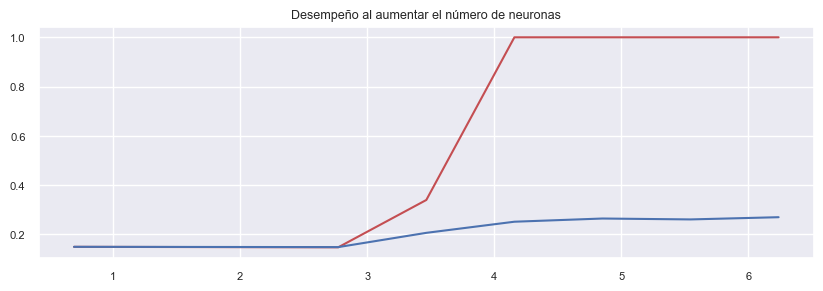

In [21]:
fig, ax = plt.subplots(figsize=(10,3),nrows=1)
p1 = plt.plot(np.log(list_nneurons),train_accuracies,color='r')
p2 = plt.plot(np.log(list_nneurons),val_accuracies,color='b')
plt.tick_params(labelsize=8)
ax.set_title('Desempeño al aumentar el número de neuronas',fontsize=9)
plt.xticks(rotation=0)
plt.show()

# P4. Modelo más Profundo

El objetivo de esta sección es que aprenda a controlar el número de capas en la red y entender sus posibles efectos.

* *Modifique el modelo base aumentando el número de capas ocultas. Si mantiene el mismo número total de neuronas ¿Aumenta o disminuye el número de parámetros entrenables? ¿Es esto conveniente desde un punto de vista computacional?* 

Si la cantidad de neuronas por capa se mantiene homogénea, al aumentar la cantidad de capas disminuirá el número total de conexiones, y por lo tanto, el número de parámetros entrenables. Sin embargo, si la distribución de neuronas por capa puede ser heterogénea, no es posible asegurar que el número de parámetros entrenables disminuya o aumente. Intuitivamente, si existe una gran varianza en la cantidad de neuronas por capa, y las capas que concentran el mayor número de neuronas son adyacentes, la cantidad de parámetros será mayor que en el caso contrario.

Un aumento en el número de parámetros entrenables implica un costo computacional mayor. De la misma forma, agregar capas a una red neuronal puede significar realizar una mayor cantidad de operaciones, lo que también termina generando un costo computacional mayor. Se debe buscar un equilibrio entre la cantidad de capas del modelo, la cantidad de parámetros entrenables y la manera en que estas características afectan la precisión de la red, para que se pueda llegar a un modelo que sea preciso y capaz de generalizar, con un costo computacional bajo.

In [19]:
NUM_PIXELS = RES_ESPACIAL*RES_ESPACIAL*CHANNELS
NUM_CLASSES = 10
NUM_NEURONS_BASE = 512

def profundo(OCULTAS = 2):
  input_temp = keras.Input(shape=(NUM_PIXELS))
  hidden_temp = Dense(NUM_NEURONS_BASE//OCULTAS, activation='relu')(input_temp)
  for i in range(OCULTAS-1):
    hidden_temp = Dense(NUM_NEURONS_BASE//OCULTAS, activation='relu')(hidden_temp) 
  outputs_temp = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden_temp)
  model_temp = tf.keras.Model(inputs=input_temp, outputs=outputs_temp) 
  return model_temp 
model = profundo(OCULTAS = 2)
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 12288)]           0         
                                                                 
 dense_30 (Dense)            (None, 256)               3145984   
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dense_32 (Dense)            (None, 10)                2570      
                                                                 
Total params: 3,214,346
Trainable params: 3,214,346
Non-trainable params: 0
_________________________________________________________________


In [20]:
from keras.callbacks import EarlyStopping
mc =  EarlyStopping(monitor='accuracy',min_delta=0,patience=10,restore_best_weights=True)

profundidades = [1,2,4,8]
train_accuracies_prof = []
val_accuracies_prof = []

for p in profundidades:
  model_temp = profundo(OCULTAS = p)
  print("PROFUNDIDAD ", p)
  model_temp.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
  history_temp = model_temp.fit(train_data_preprocessed, epochs=200, callbacks=[mc], verbose=0)
  train_accuracies_prof.append(get_accuracy(model_temp,train_data_preprocessed))
  val_accuracies_prof.append(get_accuracy(model_temp,val_data_preprocessed))


PROFUNDIDAD  1
PROFUNDIDAD  2
PROFUNDIDAD  4
PROFUNDIDAD  8


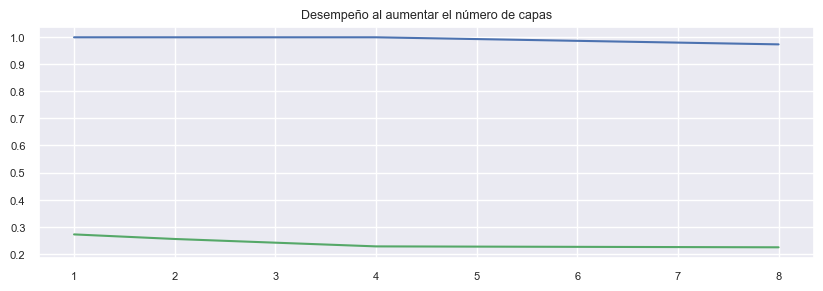

In [22]:
fig, ax = plt.subplots(figsize=(10,3),nrows=1)
p1 = plt.plot(profundidades,train_accuracies_prof,color='b')
p2 = plt.plot(profundidades,val_accuracies_prof,color='g')  
plt.tick_params(labelsize=8)
ax.set_title('Desempeño al aumentar el número de capas',fontsize=9)
plt.xticks(rotation=0)
plt.show()

In [ ]:
test_data_preprocessed = test_data.map(preprocess)
print("Accuracy Entrenamiento MODEL 2:", get_accuracy(model_2,train_data_preprocessed))
print("Accuracy Validación MODEL 2:", get_accuracy(model_2,val_data_preprocessed))
print("Accuracy Pruebas MODEL 2:", get_accuracy(model_2,test_data_preprocessed))

In [ ]:
print("Classification Report Entrenamiento MODEL 2")
print(get_report(model_2,train_data_preprocessed ))
print("Classification Report Validación MODEL 2")
print(get_report(model_2,val_data_preprocessed ))
print("Classification Report Pruebas MODEL 2")
print(get_report(model_2,test_data_preprocessed ))

# P5. Detalles de Entrenamiento

El objetivo de esta sección es que aprenda a controlar algunos hiper-parámetros importantes del entrenamiento como el tamaño de batch, el número de épocas, y la tasa de aprendizaje.

* *Determine si al aumentar/reducir el tamaño de batch, aumenta/reduce los tiempos de entrenamiento. Determine también si al aumentar/reducir el tamaño de batch, el modelo aprende más rápido/lento, definiendo claramente cómo medira la "velocidad de aprendizaje". Para este estudio, evalue sólo 2 a 4 cambios sobre el modelo, pero calibre los cambios de modo de observar un efecto significativo (por ejemplo, al cambiar de 32 a 30 no se espera gran cambio).*

Con tamaños de batch muy pequeños, el tiempo de entrenamiento es considerablemente alto, y se reduce rápidamente al aumentar el tamaño del batch. Sin embargo, tras un cierto tamaño, el tiempo comienza a aumentar lentamente.

La velocidad de aprendizaje se definirá como la mejora promedio de la precisión del modelo en cada época del entrenamiento.
No pareciera haber una relación estable entre el tamaño del batch y la velocidad de aprendizaje.

* *Determine si al aumentar el número de épocas totales el modelo efectivamente aprende más.  Para este estudio, evalue sólo 1 cambio a un número signitivamente más grande de épocas, monitoreando las métricas importantes. Razone a partie de un gráfico del tipo métrica versus época de entrenamiento.*

El modelo sí aprende más al aumentar el número de épocas, esto puede verse en la diferencia entre la precisión inicial y final de cada uno de los modelos - en el modelo con 5 épocas, la precisión aumentó en un 13% su precisión, mientras que en el modelo con 200 épocas, la precisión aumentó en un 25% aprox.

* *La teoría prevé que con tasas de aprendizaje excesivamente grandes, existe riesgo de divergencia, mientras que con tasas de aprendizaje excesivamente pequeñas el entrenamiento es muy lento. Verifique experimentalmente estas predicciones, utilizando para el entrenamiento SGD con tasa fija.*

Efectivamente, tasas muy altas provocan divergencias, lo que puede verse en una menor precisión final del modelo, y una tendencia a no seguir mejorando tras cierto punto en las épocas. Por otro lado, tasas pequeñas generan tiempos de entrenamiento muy altos, pero pueden mejorar a lo largo de una mayor cantidad de épocas.

In [163]:
import time
from keras.optimizers import SGD

def crear_modelo(tiempos, epocas=5, batch_size=64, tasa=0.1):
    nneurons =  128
    RES_ESPACIAL = 64
    CHANNELS = 3
    NUM_PIXELS = RES_ESPACIAL*RES_ESPACIAL*CHANNELS
    train_data = load_data("galaxies_INF395/train/",batch_size=batch_size, res=RES_ESPACIAL)
    
    train_data_preprocessed = train_data.map(preprocess)

    optimizer = SGD(learning_rate=tasa)
    input = keras.Input(shape=(NUM_PIXELS))
    hidden = Dense(nneurons, activation='relu')(input)  
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden)
    model = tf.keras.Model(inputs=input, outputs=outputs) 
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    start = time.time()
    history = model.fit(train_data_preprocessed, epochs=epocas, verbose=1)
    end = time.time()
    tiempos.append(end-start)

    return history

In [ ]:
BATCH_SIZE =  [16,32,64,128]
times = []
history_batches = []

for i in BATCH_SIZE:
    history_batches.append(crear_modelo(batch_size=i, tiempos=times))

In [169]:
promedios_vel = []

for i in range(len(BATCH_SIZE)):
    diffs = []
    for j in range(len(history_batches[i].history['accuracy'])):
        if j == 0:
            continue
        diffs.append(history_batches[i].history['accuracy'][j]-history_batches[i].history['accuracy'][j-1])
    # calculate the mean of the differences
    promedios_vel.append(np.mean(diffs))

for i in range(len(BATCH_SIZE)):
    print("promedio vel. aprendizaje con batch size de " + str(BATCH_SIZE[i]) +" es "+ str(promedios_vel[i]))

promedio vel. aprendizaje con batch size de 16 es 0.008062243461608887
promedio vel. aprendizaje con batch size de 32 es 0.0395120345056057
promedio vel. aprendizaje con batch size de 64 es 0.028229597955942154
promedio vel. aprendizaje con batch size de 128 es 0.027524445205926895


In [ ]:
EPOCAS = [5,20]
times_epocas = []
aprendizajes = []

for i in EPOCAS:
    aprendizajes.append(crear_modelo(epocas=i, tiempos=times_epocas, batch_size=64))

for i in range(len(EPOCAS)):
    print(aprendizajes[i].history['accuracy'][-1])
    print(aprendizajes[i].history['accuracy'][0]) 

In [175]:
for i in range(len(EPOCAS)):
    print("Accuracy final con", EPOCAS[i], "epocas", aprendizajes[i].history['accuracy'][-1], "delta de aprendizaje", aprendizajes[i].history['accuracy'][-1]-aprendizajes[i].history['accuracy'][0])

Accuracy final con 5 epocas 0.2754794955253601
Accuracy final con 25 epocas 0.45176759362220764


In [ ]:
TASA = [0.01, .1, 0.5, 1.0, 5]

history_tasas = []

times_2 = []

for i in TASA:
    history_tasas.append(crear_modelo(tasa=i, tiempos=times_2))

In [ ]:
# grafica las tasas de aprendizaje (en el eje x) versus los tiempos de entrenamiento y el accuracy final (en el eje y)
acurracy_final = []
for i in range(len(history_tasas)):
    acurracy_final.append(history_tasas[i].history['accuracy'][-1])

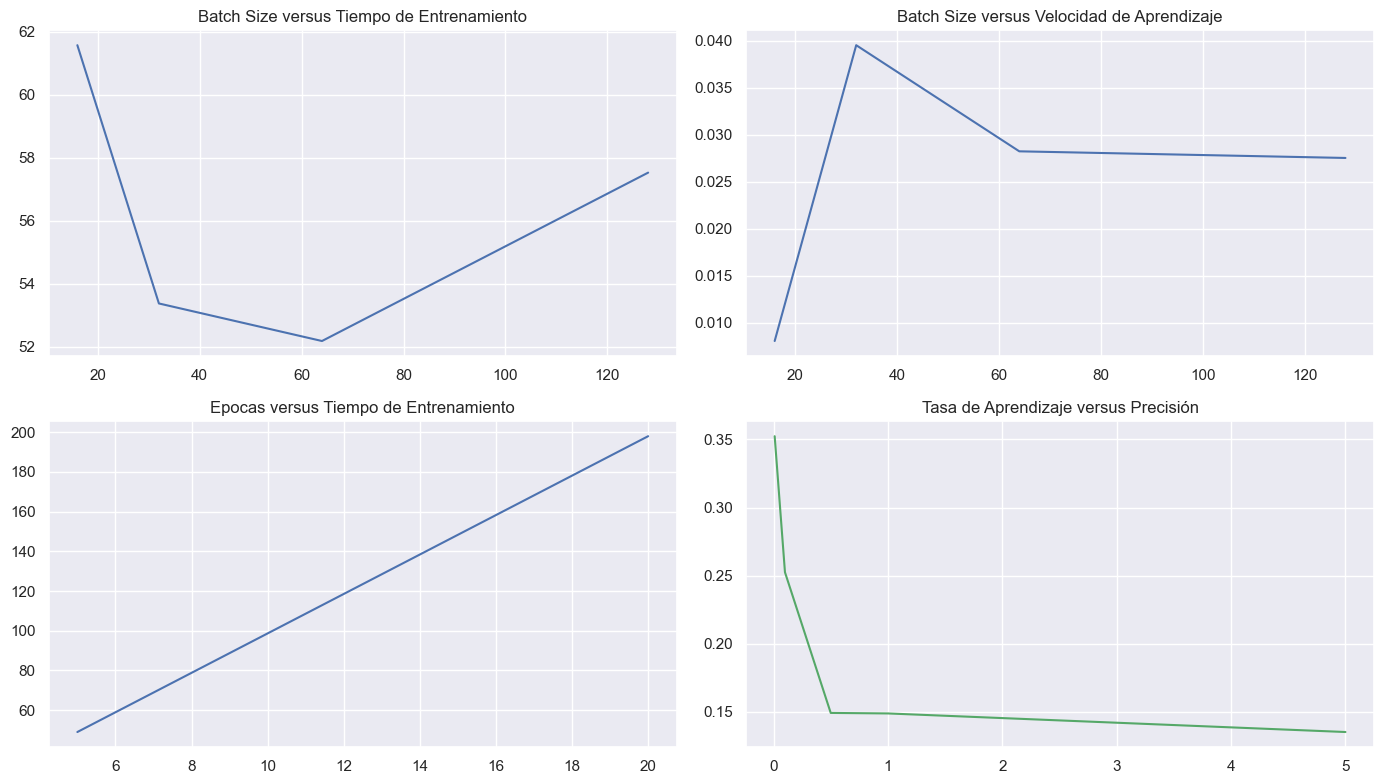

In [170]:
fig, axis = plt.subplots(2, 2, figsize=(14,8))
axis[0,0].plot(BATCH_SIZE,times,color='b')
axis[0,1].plot(BATCH_SIZE,promedios_vel,color='b')
axis[1,0].plot(EPOCAS,times_epocas,color='b')
axis[1,1].plot(TASA,acurracy_final,color='g')
axis[0,0].set_title("Batch Size versus Tiempo de Entrenamiento")
axis[0,1].set_title("Batch Size versus Velocidad de Aprendizaje")
axis[1,0].set_title("Epocas versus Tiempo de Entrenamiento")
axis[1,1].set_title("Tasa de Aprendizaje versus Precisión")
plt.tight_layout()
plt.show()

# P6. Modelo Especializado

El objetivo de esta sección es que aprenda a combinar trozos de redes posiblemente entrenadas por otros con trozos propios para su problema. Para ello, construiremos una serie de capas especializadas en visión, que estudiaremos próximamente. Por ahora, utilice esta serie capas como una caja negra que extrae características para su modelo denso tradicional.

* *¿Qué recibe como input este modelo visual?*

Un tensor, que corresponde a imágenes con 2 dimensiones que especifican la posiciones de los pixeles y una tercera que indica el canal de color.

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Rescaling, Flatten, GlobalAveragePooling2D

RES_ESPACIAL = 16

########## MODELO VISUAL ESPECIALIZADO (lo estudiaremos pronto) ##########
image_raw = keras.Input(shape=(RES_ESPACIAL,RES_ESPACIAL,CHANNELS))
image_scaled = Rescaling(scale=1/255.0)(image_raw)
visual = Conv2D(32,(3,3),activation='relu',padding='same')(image_scaled)
visual = Conv2D(32,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(64,(3,3),activation='relu',padding='same')(visual)
visual = Conv2D(64,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(128,(3,3),activation='relu',padding='same')(visual)
features = GlobalAveragePooling2D()(visual)

model_visual = tf.keras.Model(inputs=image_raw, outputs=features) 
model_visual.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 16, 16, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                           

* *Defina una red similar a la del modelo base, pero que se alimente de las características extraídas desde la red especializada definida más arriba. ¿De qué tamaño es el input de la parte que construye sobre el modelo anterior? ¿Cómo se ensamblan las dos piezas? ¿Qué trozo tiene más parámetros libres?*

El tamaño del input de esta nueva parte es igual al tamaño del output de la red convolucional anterior - 128 neuronas.

Se crea una capa densa que se conecta al output de la red convolucional anterior.

El trozo anterior tiene más parámetros libres con 139.424, contra los 35.594 del trozo nuevo.

In [17]:
########## PARTE DENSA TRADICIONAL ##########
hidden =  Dense(256, activation='relu')(model_visual.output)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
trozo_nuevo = tf.keras.Model(inputs=model_visual.output, outputs=outputs)  
#trozo_nuevo.summary()

########## ENSAMBLAMOS LAS PIEZAS ##########
model_combinado = tf.keras.Model(inputs=model_visual.input, outputs=outputs)  
model_combinado.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 16, 16, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                           

## Entrenamiento 

* *Intente entrenar el modelo completo por unas 30 épocas. Si no lo consigue intente cambios que se lo permitan como por ejemplo: reducir la resolución de las imágenes, reducir el número de épocas, o trabajar con la colección pequeña de entrenamiento.*

In [18]:
BATCH_SIZE = 256
RES_ESPACIAL = 16

train_data = load_data("galaxies_INF395/train/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
val_data = load_data("galaxies_INF395/val/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
test_data = load_data("galaxies_INF395/test/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

Found 10636 files belonging to 10 classes.
Found 3542 files belonging to 10 classes.
Found 3558 files belonging to 10 classes.


In [19]:
optimizer = Adam()
model_combinado.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_combinado = model_combinado.fit(train_data, epochs=30, validation_data=val_data)

Epoch 1/30
42/42 [==============================] - 15s 300ms/step - loss: 2.2288 - accuracy: 0.1469 - val_loss: 2.1885 - val_accuracy: 0.1889
Epoch 2/30
42/42 [==============================] - 14s 297ms/step - loss: 2.1016 - accuracy: 0.2079 - val_loss: 2.0023 - val_accuracy: 0.2312
Epoch 3/30
42/42 [==============================] - 16s 343ms/step - loss: 1.9706 - accuracy: 0.2461 - val_loss: 1.9096 - val_accuracy: 0.2527
Epoch 4/30
42/42 [==============================] - 14s 296ms/step - loss: 1.8754 - accuracy: 0.3082 - val_loss: 1.7819 - val_accuracy: 0.3315
Epoch 5/30
42/42 [==============================] - 15s 332ms/step - loss: 1.7486 - accuracy: 0.3490 - val_loss: 1.7265 - val_accuracy: 0.3659
Epoch 6/30
42/42 [==============================] - 16s 355ms/step - loss: 1.6344 - accuracy: 0.3908 - val_loss: 1.5756 - val_accuracy: 0.4300
Epoch 7/30
42/42 [==============================] - 16s 343ms/step - loss: 1.5550 - accuracy: 0.4237 - val_loss: 1.4875 - val_accuracy: 0.4656

* *¿Aprende mejor este modelo? ¿Generaliza mejor?*

Este modelo pareciera ser más efectivo en generalizar que el modelo anterior propuesto, lo que se puede notar en que en la décima época, el accuracy sobre el dataset de validación es algo mayor que lo que se logró con modelos anteriores, con 49% contra un 46%. Cabe notar que se debió reducir la resolución de las imágenes a 16x16 y aumentar al batch size a 256 para que el modelo pudiera ser entrenado con 30 épocas en un tiempo aceptable.

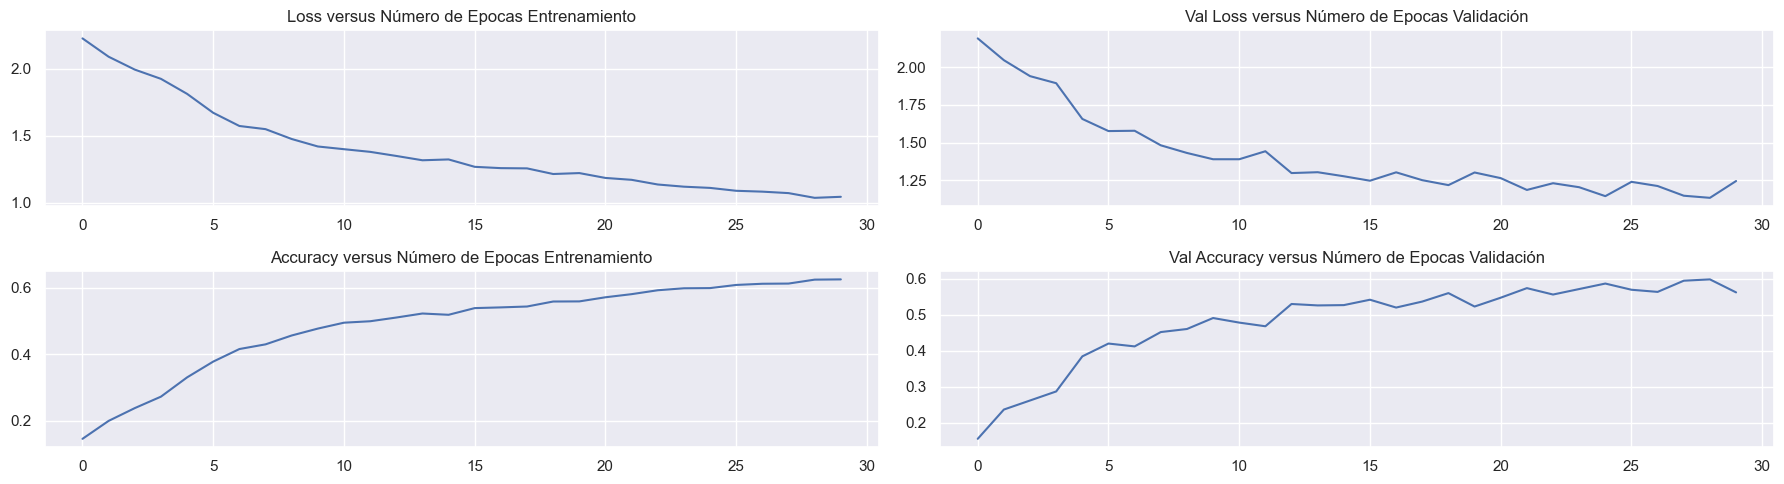

In [37]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(2, 2, figsize=(18,5))
axis[0,0].plot(history_combinado.history['loss'], label='train loss')
axis[0,1].plot(history_combinado.history['val_loss'], label='val loss')
axis[1,0].plot(history_combinado.history['accuracy'], label='train acc')
axis[1,1].plot(history_combinado.history['val_accuracy'], label='val acc')
axis[0,0].set_title("Loss versus Número de Epocas Entrenamiento")
axis[0,1].set_title("Val Loss versus Número de Epocas Validación")
axis[1,0].set_title("Accuracy versus Número de Epocas Entrenamiento")
axis[1,1].set_title("Val Accuracy versus Número de Epocas Validación")
plt.tight_layout()
plt.show()

* *¿Mejora el desempeño de las clases de galaxia peor detectadas por el modelo denso de partida?*

Sí, mejora notoriamente. Para la clase "Disk_Edge-on_Rounded_Bulge", que en el modelo anterior tenía una precisión menor a 20% (la menor de todas), la precisión aumentó más de 40%. También para la segunda clase con menor precisión en el modelo anterior "Disk_Face-on_No_Spiral", que tenía una precisión menor a 30%, esta aumentó a una precisión sobre 50%.

In [38]:
print("Classification Report Entrenamiento MODELO COMBINADO")
print(get_report(model_combinado,train_data))
print("Classification Report Validación MODELO COMBINADO")
print(get_report(model_combinado,val_data))
print("Classification Report Pruebas MODELO COMBINADO")
print(get_report(model_combinado,test_data))

Classification Report Entrenamiento MODELO COMBINADO
                            precision    recall  f1-score   support

   Disk_Edge-on_Boxy_Bulge       0.52      0.36      0.42      1225
     Disk_Edge-on_No_Bulge       0.48      0.45      0.47      1097
Disk_Edge-on_Rounded_Bulge       0.48      0.15      0.23       200
 Disk_Face-on_Loose_Spiral       0.69      0.81      0.75      1123
Disk_Face-on_Medium_Spiral       0.72      0.93      0.81       853
    Disk_Face-on_No_Spiral       0.54      0.16      0.24       648
 Disk_Face-on_Tight_Spiral       0.41      0.59      0.49      1576
       Smooth_Cigar_shaped       0.58      0.75      0.65      1216
   Smooth_Completely_round       0.62      0.69      0.65      1111
   Smooth_in-between_round       0.92      0.59      0.72      1587

                  accuracy                           0.59     10636
                 macro avg       0.60      0.55      0.54     10636
              weighted avg       0.61      0.59      0.58    

## Guardar (Opcional)

El código de más abajo guarda la parte del modelo anterior que extrae características visuales. Si usted entrenó un modelo con buen desempeño puede valer la pena ejecutar este paso.


In [50]:
#Esto guarda la parte del modelo anterior que extrae características visuales
model_visual = tf.keras.Model(inputs=image_raw, outputs=features) 
model_visual.summary()
model_visual.save('modelo_visual_entrenado_nombre_elegido.h5')

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 16, 16, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 16, 16, 3)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 64)          18496     
                                                          

# P7. Modelo Recargado

El objetivo de esta sección es que aprenda a cargar un modelo entrenado y salvado por otra persona (posiblemente un compañero de equipo) para iniciar un entrenamiento fino o un uso nuevo de las características aprendidas.



* *Cargue el modelo entrenado distribuido con esta tarea y úselo para crear un nuevo modelo combinado similar al anterior. ¿Cuántos parámetros tiene el modelo que cargó?*

In [ ]:
#OMITIR ESTA LÍNEA SI CARGÓ EL ARCHIVO DIRECTAMENTE EN LA MÁQUINA VIRTUAL
#O BIEN ADÁPTELA AL PATH DE SU REPOSITORIO EN LA NUBE
!cp "/content/drive/My Drive/Taller1-B/modelo_visual_entrenado.h5" .

In [25]:
#ESTO CARGA UN MODELO VISUAL YA ENTRENADO DECLARANDOLO NO ENTRENABLE
mi_modelo_visual = keras.models.load_model('modelo_visual_entrenado.h5')
mi_modelo_visual.trainable = False
mi_modelo_visual.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        18496     
                                                          

In [11]:
#ESTO EXTIENDE EL MODELO ANTERIOR CON CAPAS NUEVAS ENTRENABLES
hidden =  Dense(256, activation='relu')(mi_modelo_visual.output)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
model_recargado = tf.keras.Model(inputs=mi_modelo_visual.input, outputs=outputs) 

* *¿Cuántos parámetros entrenables tiene el modelo combinado creado? ¿Coincide con la suma de las dos partes? ¿Porqué?*

Tiene 35.594 parámetros entrenables, lo cual no coincide con la suma de las dos partes, porque los parámetros del modelo anterior ya no pueden ser re-entrenados.

In [28]:
model_recargado.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        18496     
                                                          

In [ ]:
BATCH_SIZE = 256
RES_ESPACIAL = 64

train_data = load_data("galaxies_INF395/train/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
val_data = load_data("galaxies_INF395/val/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
test_data = load_data("galaxies_INF395/test/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

optimizer = Adam()
model_recargado.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_recargado = model_recargado.fit(train_data, epochs=20, validation_data=val_data)

* *¿Aprende mejor este modelo respecto de los modelos que entrenó anteriormente? ¿Generaliza mejor?*

Este modelo tiene una precisión considerablemente más alta que los modelos anteriores, tanto para los datos de entrenamiento como para los datos de validación. Sin embargo, tras 20 épocas de entrenamiento, el modelo no mejoró mucho en su precisión, por lo que no puede decirse que aprenda mejor que los modelos anteriores.

In [ ]:
print("Accuracy Entrenamiento MODELO RECARGADO:", get_accuracy(model_recargado,train_data))
print("Accuracy Validación MODELO RECARGADO:", get_accuracy(model_recargado,val_data))
print("Accuracy Pruebas MODELO RECARGADO:", get_accuracy(model_recargado,test_data))

print("Classification Report Entrenamiento MODEL ESPECIALIZADO")
print(get_report(model_recargado,train_data))
print("Classification Report Validación MODEL ESPECIALIZADO")
print(get_report(model_recargado,val_data))
print("Classification Report Pruebas MODEL ESPECIALIZADO")
print(get_report(model_recargado,test_data))

## Pre-procesando los datos.

Si por razones computacionales, no puede entrenar el modelo recargado, una opción es aplicarlo a los datos antes de cualquier entrenamiento y definir solo el trozo extra.

In [26]:
def preprocess_visual(x,y):
  return mi_modelo_visual(x),y

train_data_visual_features = train_data.map(preprocess_visual)
val_data_visual_features = val_data.map(preprocess_visual)

In [ ]:
#for x,y in train_data_visual_features:
#  print(x.numpy().shape,y.numpy().shape)

In [40]:
N_VISUAL_FEATURES=128
NUM_CLASSES=10
image_preprocesada = keras.Input(shape=(N_VISUAL_FEATURES))
hidden =  Dense(256, activation='relu')(image_preprocesada)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
model_recargado_preprocesado = tf.keras.Model(inputs=image_preprocesada, outputs=outputs) 

In [41]:
optimizer = Adam()
model_recargado_preprocesado.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_recargado_preprocesado = model_recargado_preprocesado.fit(train_data_visual_features, epochs=2, validation_data=val_data_visual_features)

Epoch 1/2
42/42 [==============================] - 64s 1s/step - loss: 1.4709 - accuracy: 0.5713 - val_loss: 1.0879 - val_accuracy: 0.6567
Epoch 2/2
42/42 [==============================] - 64s 2s/step - loss: 0.9056 - accuracy: 0.7134 - val_loss: 0.9213 - val_accuracy: 0.6928


* Determine si disminuyendo/aumentando el número de neuronas ocultas del modelo construido más arriba (256 unidades ocultas), se deteriora/mejora la capacidad predictiva del modelo. Investigue también si agregando capas ocultas extras obtiene mejores resultados.

Para el mismo numero de capas, al aumentar el número de neuronas ocultas, el modelo mejora su precisión rapidamente hasta aproximadamente 220 neuronas, despues de eso sigue mejorando, pero es casi insignificante el cambio. Al aumentar el número de capas, el modelo mejora su precisión, pero aumenta mas lentamente a medida que crece el numero de capas.

In [ ]:
from keras.callbacks import EarlyStopping
mc =  EarlyStopping(monitor='accuracy',min_delta=0.01,patience=10,restore_best_weights=True)
N_VISUAL_FEATURES=128

list_nneurons_recargado = [2, 256, 1024]
train_accuracies_recargado = []
val_accuracies_recargado = []

for nneurons in list_nneurons_recargado:
  image_preprocesada = keras.Input(shape=(N_VISUAL_FEATURES))
  hidden =  Dense(nneurons, activation='relu')(image_preprocesada)
  outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
  model_recargado_preprocesado = tf.keras.Model(inputs=image_preprocesada, outputs=outputs) 
  model_recargado_preprocesado.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  history_recargado_preprocesado = model_recargado_preprocesado.fit(train_data_visual_features, callbacks=[mc], epochs=2, verbose=1)
  train_accuracies_recargado.append(get_accuracy(model_recargado_preprocesado,train_data_visual_features))
  val_accuracies_recargado.append(get_accuracy(model_recargado_preprocesado,val_data_visual_features ))


In [72]:
N_VISUAL_FEATURES=128
NUM_CLASSES=10

profundidades = [1,2,3,4]
train_accuracies_recargado_prof = []
val_accuracies_recargado_prof = []

for p in profundidades:
  image_preprocesada = keras.Input(shape=(N_VISUAL_FEATURES))
  hidden_temp =  Dense(32, activation='relu')(image_preprocesada)
  for i in range(p-1):
    hidden_temp = Dense(NUM_NEURONS_BASE//p, activation='relu')(hidden_temp) 
  outputs_temp = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden_temp)
  model_temp = tf.keras.Model(inputs=image_preprocesada, outputs=outputs_temp) 
  print("PROFUNDIDAD ", p)
  model_temp.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
  history_temp = model_temp.fit(train_data_visual_features, epochs=5, callbacks=[mc], verbose=1)
  train_accuracies_recargado_prof.append(get_accuracy(model_temp,train_data_visual_features))
  val_accuracies_recargado_prof.append(get_accuracy(model_temp,val_data_visual_features))

PROFUNDIDAD  1
Epoch 1/5
42/42 [==============================] - 45s 1s/step - loss: 2.2898 - accuracy: 0.1582
Epoch 2/5
42/42 [==============================] - 41s 963ms/step - loss: 2.2608 - accuracy: 0.1486
Epoch 3/5
42/42 [==============================] - 41s 963ms/step - loss: 2.2304 - accuracy: 0.1482
Epoch 4/5
42/42 [==============================] - 41s 965ms/step - loss: 2.2048 - accuracy: 0.2434
Epoch 5/5
42/42 [==============================] - 41s 961ms/step - loss: 2.1820 - accuracy: 0.2811
PROFUNDIDAD  2
Epoch 1/5
42/42 [==============================] - 42s 968ms/step - loss: 2.2673 - accuracy: 0.1972
Epoch 2/5
42/42 [==============================] - 42s 971ms/step - loss: 2.1917 - accuracy: 0.1787
Epoch 3/5
42/42 [==============================] - 42s 970ms/step - loss: 2.0890 - accuracy: 0.2670
Epoch 4/5
42/42 [==============================] - 41s 967ms/step - loss: 1.8999 - accuracy: 0.3446
Epoch 5/5
42/42 [==============================] - 41s 966ms/step - loss:

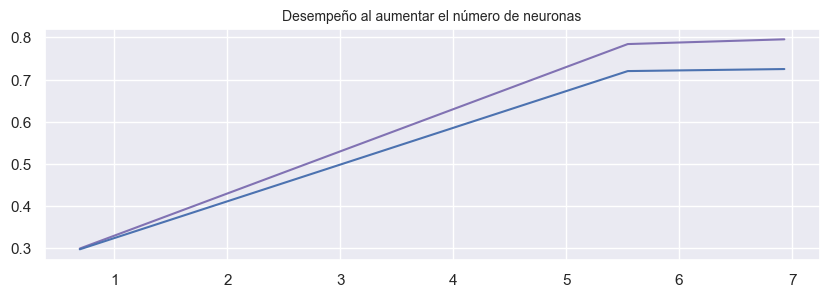

In [50]:
fig, ax = plt.subplots(figsize=(10,3),nrows=1)
p1 = plt.plot(np.log(list_nneurons_recargado),train_accuracies_recargado,color='m')
p2 = plt.plot(np.log(list_nneurons_recargado),val_accuracies_recargado,color='m')
b.tick_params(labelsize=9)
ax.set_title('Desempeño al aumentar el número de neuronas',fontsize=10)
plt.xticks(rotation=0)
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
ax[0].plot(list_nneurons_recargado,train_accuracies_recargado,color='m')
ax[0].plot(list_nneurons_recargado,val_accuracies_recargado,color='b')
ax[1].plot(profundidades,train_accuracies_recargado_prof,color='m')
ax[1].plot(profundidades,val_accuracies_recargado_prof,color='b')
ax[0].set_title('Desempeño al aumentar el número de neuronas',fontsize=10)
ax[1].set_title('Desempeño al aumentar el número de capas',fontsize=10)
plt.show()

# P8. Embeddings

El objetivo de esta sección es que explore las características que aprende la red. En el caso de que su modelo tenga 1 capa oculta de M neuronas, podemos "proyectar" esas M características en el plano para visualizar si las clases se separan correctamente o no. Una técnica para hacer esto es TSNE. 

* *Determine visualmente si las características que aprende su modelo son mejores que las características originales de las imágenes (pixeles) para separar las diferentes clases de galaxias. Como modelo, utilice el que construimos en P7 usando el modelo recargado.*

Al comparar los dos gráficos, se puede notar que las características extraídas por el modelo son más eficaces en separar los tipos - en la imagen de la derecha se puede ver que los colores similares (de la misma clase) tienden a estar más cerca en el plano. Por otro lado, en la imagen de la izquierda, donde se proyectaron los 12288 parámetros de las imágenes (valores de los pixéles en los 3 canales) hacia un plano bidimensional, no se ve una distribución en el plano que esté relacionada con la categoría a la que pertenecen.

In [39]:
from sklearn.manifold import TSNE

In [36]:
#Funcion que extrae explícitamente arreglos de datos desde un Dataset "virtual".
#reducir "limitar2 si tiene muchos problemas de memoria

def get_XY(TFdataset,limitar=100000000):
  features = []
  etiquetas = []
  counter=0
  for x,y in TFdataset: 
    features.append(x.numpy())
    etiquetas.append(y.numpy())
    if counter>limitar:
      break
    counter+=1
  print(counter)
  X = np.vstack(features)
  y = np.vstack(etiquetas)
  return X,y

In [35]:
def preprocess(x,y):#esto escala y transforma las imagenes en vectores
  normalization_layer = tf.keras.layers.Rescaling(1./255)
  return tf.reshape(normalization_layer(x),(-1,RES_ESPACIAL*RES_ESPACIAL*CHANNELS)),y

train_data_preprocessed = train_data.map(preprocess)
X, y = get_XY(train_data_preprocessed,1000)
X_embedded_original = TSNE(n_components=2).fit_transform(X)
print(X.shape, " ===> ", X_embedded_original.shape)

333
(10636, 12288)  ===>  (10636, 2)


In [39]:
print(train_data_preprocessed)

333


In [31]:
def scaleonly(x,y):#esto es para escalar las caracteristicas extraidas por el modelo
  normalization_layer = tf.keras.layers.Rescaling(1./255)
  return normalization_layer(x),y


In [25]:
#train_data_visual_features fue obtenido en P7.
train_data_visual_features = train_data_visual_features.map(scaleonly)
Xv, yv = get_XY(train_data_visual_features,1000)
print(Xv.shape)
X_embedded_visual = TSNE(n_components=2).fit_transform(Xv)
print(Xv.shape, " ===> ", X_embedded_visual.shape)

(10636, 128)
(10636, 128)  ===>  (10636, 2)


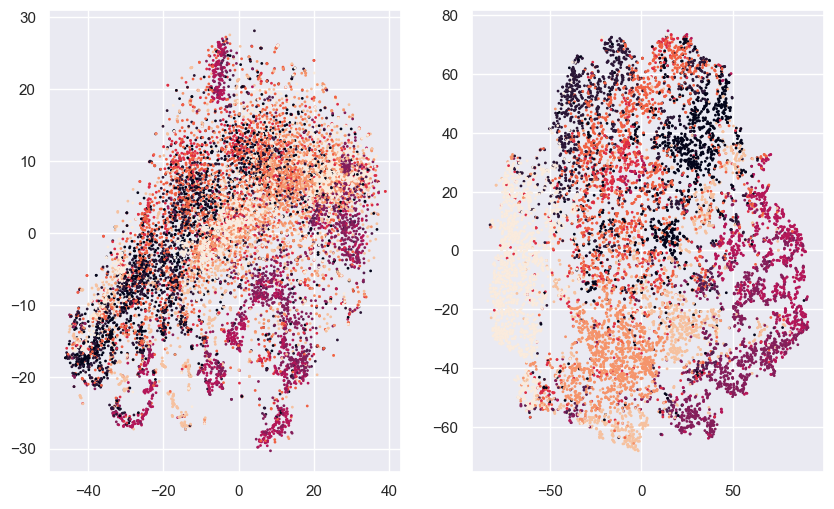

In [15]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1,ncols=2)
ax[0].scatter(X_embedded_original[:,0],X_embedded_original[:,1],c=np.argmax(y,axis=1),s=1)
ax[1].scatter(X_embedded_visual[:,0],X_embedded_visual[:,1],c=np.argmax(yv,axis=1),s=1)
plt.show()

* *Determine si aumentando la profundidad de su modelo, se obtienen mejores características.*

Al aumentar la profundidad del modelo se puede observar que los embeddings generados agrupan aún más los datos que pertenecen a la misma clase (mirar la imagen de la derecha en la figura de abajo). Esto significa que las características obtenidas tienen valores que son más cercanos si las imágenes pertenecen a una misma clase, que es justamente lo que se está buscando con el entrenamiento.

In [27]:
N_VISUAL_FEATURES=128
NUM_CLASSES = 10
image_preprocesada = keras.Input(shape=(N_VISUAL_FEATURES))
hidden =  Dense(256, activation='relu')(image_preprocesada)
hidden =  Dense(128, activation='relu')(hidden)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
model_recargado_profundo = tf.keras.Model(inputs=image_preprocesada, outputs=outputs) 
model_recargado_profundo.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
history_recargado_profundo = model_recargado_profundo.fit(train_data_visual_features, epochs=10)


Epoch 1/10
333/333 [==============================] - 56s 166ms/step - loss: 0.8860 - accuracy: 0.7066
Epoch 2/10
333/333 [==============================] - 56s 169ms/step - loss: 0.6420 - accuracy: 0.7826
Epoch 3/10
333/333 [==============================] - 60s 179ms/step - loss: 0.5906 - accuracy: 0.7963
Epoch 4/10
333/333 [==============================] - 65s 193ms/step - loss: 0.5640 - accuracy: 0.8054
Epoch 5/10
333/333 [==============================] - 63s 187ms/step - loss: 0.5468 - accuracy: 0.8122
Epoch 6/10
333/333 [==============================] - 60s 180ms/step - loss: 0.5337 - accuracy: 0.8147
Epoch 7/10
333/333 [==============================] - 62s 184ms/step - loss: 0.5165 - accuracy: 0.8188
Epoch 8/10
333/333 [==============================] - 60s 179ms/step - loss: 0.5059 - accuracy: 0.8219
Epoch 9/10
333/333 [==============================] - 60s 180ms/step - loss: 0.4979 - accuracy: 0.8261
Epoch 10/10
333/333 [==============================] - 63s 188ms/step - l

In [52]:
model_recargado_profundo.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 67,210
Trainable params: 67,210
Non-trainable params: 0
_________________________________________________________________


In [34]:
from keras import backend as K

def extrae_una_capa(x,y):
  return embedding_function(x),y

capa_interes = 0
embedding_function = tf.keras.Model(inputs=model_recargado_profundo.input, outputs=model_recargado_profundo.layers[capa_interes].output) 

train_data_deep_features = train_data_visual_features.map(extrae_una_capa)


In [40]:
train_data_deep_features = train_data_deep_features.map(scaleonly)
Xd, yd = get_XY(train_data_deep_features,1000)
print(Xd.shape)
X_embedded_deep = TSNE(n_components=2).fit_transform(Xd)
print(Xd.shape, " ===> ", X_embedded_deep.shape)

333
(10636, 128)
(10636, 128)  ===>  (10636, 2)


In [41]:
def extrae_una_capa2(x,y):
  return embedding_function2(x),y

capa_interes2 = 1
embedding_function2 = tf.keras.Model(inputs=model_recargado_profundo.input, outputs=model_recargado_profundo.layers[capa_interes2].output) 

train_data_deep_features2 = train_data_visual_features.map(extrae_una_capa2)


In [42]:
train_data_deep_features2 = train_data_deep_features2.map(scaleonly)
Xd2, yd2 = get_XY(train_data_deep_features2,1000)
print(Xd2.shape)
X_embedded_deep2 = TSNE(n_components=2).fit_transform(Xd2)
print(Xd2.shape, " ===> ", X_embedded_deep2.shape)

333
(10636, 256)
(10636, 256)  ===>  (10636, 2)


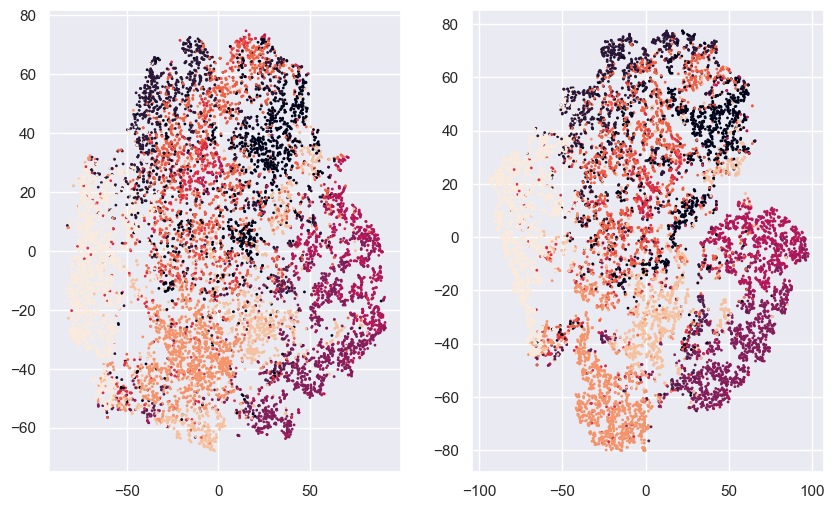

In [65]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1,ncols=2)
ax[0].scatter(X_embedded_deep[:,0],X_embedded_deep[:,1],c=np.argmax(yd,axis=1),s=1)
ax[1].scatter(X_embedded_deep2[:,0],X_embedded_deep2[:,1],c=np.argmax(yd2,axis=1),s=1)
plt.show()

* *Para finalizar esta sección, se le pide proponer una forma de aprovechar los embeddings extraidos por su red. Imagine que sólo dispone de ellos y que debe inventarse un modo de clasificar imágenes con ellos. Proponga e implemente un método sencillo que no requiera entrenar una red neuronal.*

El método consiste en utilizar los embeddings del dataset de entrenamiento, dividir el plano en "cuadrantes", dentro de los cuales se contarían la cantidad de veces que aparece cada clase (según los puntos que estarían dentro de ese cuadrante). Luego, se crea una matriz que asigna una clase a cada cuadrante según la que haya aparecido con mayor frecuencia dentro de ese cuadrante. Por último, se utiliza esta matriz para clasificar embeddings nuevos que correspondan a puntos dentro del plano cartesiano. De esta manera se estarían clasificando imágenes sin necesidad de entrenar una red neuronal.

In [75]:
X_INICIAL = -100
X_FINAL = 100
Y_INICIAL = -80
Y_FINAL = 80
STEP_X = 50
STEP_Y = 20

grilla = []
contador = 0

for i in range(0, 8):
    grilla.append([])
    for j in range(0, 4):
        grilla[i].append([])

for punto in X_embedded_deep2:
    x = punto[0]
    y = punto[1]
    if x >= X_INICIAL and x < X_FINAL and y >= Y_INICIAL and y < Y_FINAL:
        i = int((y - Y_INICIAL) / STEP_Y)
        j = int((x - X_INICIAL) / STEP_X)
        grilla[i][j].append(np.argmax(yd2[contador]))
    contador += 1


grilla_clasif = []
for i in range(0, 8):
    grilla_clasif.append([])
    for j in range(0, 4):
        grilla_clasif[i].append([])
        if len(grilla[i][j]) > 0:
            grilla_clasif[i][j].append(max(set(grilla[i][j]), key=grilla[i][j].count))

      
def clasificador(grilla_clasificadora, dataset_embedeado, x_inicial, x_final, y_inicial, y_final, step_x, step_y):
    clases = []
    for punto in dataset_embedeado:
        x = punto[1]
        y = punto[0]
        if x >= x_inicial and x < x_final and y >= y_inicial and y < y_final:
            i = int((x - x_inicial) / step_x)
            j = int((y - y_inicial) / step_y)
            clases.append(grilla_clasificadora[i][j])
    return clases


# P9. Creando Más Data

* *El objetivo de esta sección es que aprenda a generar imágenes artificiales para aumentar el conjunto de entrenamiento. Para ello usaremos generadores. Comience averiguando qué hace la clase "ImageDataGenerator" utilizada más abajo y en qué escenarios esto podría ayudar a obtener mejores resultados.*

La clase ImageDataGenerator genera batches de datos de imágenes tensoriales. Esto es útil cuando se tienen pocos datos de entrenamiento.

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

asignar_parametros()

train_generator = train_datagen.flow_from_directory(
        "galaxies_INF395/train/",
        target_size=(RES_ESPACIAL,RES_ESPACIAL),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        "galaxies_INF395/val/",
        target_size=(RES_ESPACIAL,RES_ESPACIAL),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode='categorical')


Found 10636 images belonging to 10 classes.
Found 3542 images belonging to 10 classes.


* *Replicando alguna de las técnicas utilizadas en P7 (extensión del modelo o pre-procesamiento usando modelo pre-entrenado), determine si generar imágenes "virtuales" mejora los resultados del reconocedor de galaxias.*

No mejoraron los resultados al comparar los modelos recargado/aumentado con datos generados y con los datos originales. Esto puede deberse a que, al aumentar la cantidad de datos, se está aumentando la complejidad del modelo, lo cual hace que el modelo sea más difícil de entrenar y por lo tanto, no mejore tanto su desempeño para el mismo número de épocas.

In [10]:
#ESTO CARGA UN MODELO VISUAL YA ENTRENADO DECLARANDOLO NO ENTRENABLE
mi_modelo_visual = keras.models.load_model('modelo_visual_entrenado.h5', compile=False)
mi_modelo_visual.trainable = False

hidden_aumentado =  Dense(256, activation='relu')(mi_modelo_visual.output)
outputs_aumentado = Dense(NUM_CLASSES, activation='softmax')(hidden_aumentado)
model_aumentado = tf.keras.Model(inputs=mi_modelo_visual.input, outputs=outputs_aumentado) 
model_aumentado.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        18496     
                                                           

In [11]:
model_aumentado.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history_aumentado = model_aumentado.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
333/333 [==============================] - 193s 578ms/step - loss: 1.0801 - accuracy: 0.6418 - val_loss: 0.9226 - val_accuracy: 0.6863
Epoch 2/10
333/333 [==============================] - 46s 138ms/step - loss: 0.8375 - accuracy: 0.7197 - val_loss: 0.8859 - val_accuracy: 0.7007
Epoch 3/10
333/333 [==============================] - 46s 137ms/step - loss: 0.7906 - accuracy: 0.7302 - val_loss: 0.8080 - val_accuracy: 0.7188
Epoch 4/10
333/333 [==============================] - 45s 136ms/step - loss: 0.7842 - accuracy: 0.7370 - val_loss: 0.7968 - val_accuracy: 0.7219
Epoch 5/10
333/333 [==============================] - 55s 165ms/step - loss: 0.7574 - accuracy: 0.7442 - val_loss: 0.7989 - val_accuracy: 0.7211
Epoch 6/10
333/333 [==============================] - 52s 156ms/step - loss: 0.7474 - accuracy: 0.7490 - val_loss: 0.8069 - val_accuracy: 0.7281
Epoch 7/10
333/333 [==============================] - 49s 148ms/step - loss: 0.7423 - accuracy: 0.7462 - val_loss: 0.7930 - val_a

In [12]:
print(history_aumentado.history['val_accuracy'][-1])

0.7300959825515747


In [15]:
# Modelo del ejercicio 7 (el modelo "recargado")

asignar_parametros()

mi_modelo_visual = keras.models.load_model('modelo_visual_entrenado.h5', compile=False)
mi_modelo_visual.trainable = False

hidden =  Dense(256, activation='relu')(mi_modelo_visual.output)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
model_recargado = tf.keras.Model(inputs=mi_modelo_visual.input, outputs=outputs) 
model_recargado.summary()

optimizer = Adam()
model_recargado.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_recargado = model_recargado.fit(train_data, epochs=10, validation_data=val_data)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        18496     
                                                           

* *Si su respuesta a la pregunta anterior fue negativa y tiene la capacidad de entrenar el modelo visual, determine si, haciendo este cambio, cambia su respuesta.*

Nuevamente, el modelo con datos aumentados no mejora respecto al modelo con los datos originales. Pareciera que para este caso particular la generación de datos no es efectiva.

In [20]:
# Modelo del ejercicio 6 con datos aumentados

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Rescaling, Flatten, GlobalAveragePooling2D

BATCH_SIZE = 256
NUM_CLASSES = 10
RES_ESPACIAL = 16

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        "galaxies_INF395/train/",
        target_size=(RES_ESPACIAL,RES_ESPACIAL),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        "galaxies_INF395/val/",
        target_size=(RES_ESPACIAL,RES_ESPACIAL),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode='categorical')

########## MODELO VISUAL ESPECIALIZADO (lo estudiaremos pronto) ##########
image_raw = keras.Input(shape=(RES_ESPACIAL,RES_ESPACIAL,CHANNELS))
image_scaled = tf.keras.layers.Rescaling(scale=1/255.0)(image_raw)
visual = Conv2D(32,(3,3),activation='relu',padding='same')(image_scaled)
visual = Conv2D(32,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(64,(3,3),activation='relu',padding='same')(visual)
visual = Conv2D(64,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(128,(3,3),activation='relu',padding='same')(visual)
features = GlobalAveragePooling2D()(visual)

model_visual = tf.keras.Model(inputs=image_raw, outputs=features) 

########## PARTE DENSA TRADICIONAL ##########
hidden =  Dense(256, activation='relu')(model_visual.output)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
trozo_nuevo = tf.keras.Model(inputs=model_visual.output, outputs=outputs)  
#trozo_nuevo.summary()

########## ENSAMBLAMOS LAS PIEZAS ##########
model_combinado = tf.keras.Model(inputs=model_visual.input, outputs=outputs)  

optimizer = Adam()
model_combinado.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_combinado = model_combinado.fit(train_generator, epochs=30, validation_data=validation_generator)

Found 10636 images belonging to 10 classes.
Found 3542 images belonging to 10 classes.
Epoch 1/30
42/42 [==============================] - 34s 798ms/step - loss: 2.2252 - accuracy: 0.1437 - val_loss: 2.1986 - val_accuracy: 0.1211
Epoch 2/30
42/42 [==============================] - 38s 917ms/step - loss: 2.1042 - accuracy: 0.2116 - val_loss: 2.0110 - val_accuracy: 0.2357
Epoch 3/30
42/42 [==============================] - 35s 844ms/step - loss: 1.9970 - accuracy: 0.2306 - val_loss: 1.9887 - val_accuracy: 0.2456
Epoch 4/30
42/42 [==============================] - 37s 870ms/step - loss: 1.9499 - accuracy: 0.2555 - val_loss: 1.8950 - val_accuracy: 0.2761
Epoch 5/30
42/42 [==============================] - 38s 910ms/step - loss: 1.8857 - accuracy: 0.2900 - val_loss: 1.8591 - val_accuracy: 0.3139
Epoch 6/30
42/42 [==============================] - 36s 850ms/step - loss: 1.8129 - accuracy: 0.3317 - val_loss: 1.7623 - val_accuracy: 0.3560
Epoch 7/30
42/42 [==============================] - 38s

# P10. Hyper-tuneo

El objetivo de esta sección es que aprenda a seleccionar algunos hyper-parámetros importantes de la arquitectura de la red. El objetivo no es que obtenga una super red, sino que entienda cómo hacer correctamente esto en el futuro.

In [ ]:
!pip install keras-tuner

In [87]:
import keras_tuner as kt
from tensorflow import keras

In [104]:
redtrain_data = load_data("galaxies_INF395/reduced_train/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
val_data = load_data("galaxies_INF395/val/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
redtrain_data_visual_features = redtrain_data.map(preprocess_visual)
val_data_visual_features = val_data.map(preprocess_visual)

Found 536 files belonging to 10 classes.
Found 3542 files belonging to 10 classes.


*   *Utilice la herramienta anterior para definir una estrategia que determine el número de capas, número de neuronas, y learning rate. Expliqué qué métrica monitorearía y sobre qué conjunto de datos. ¿Tiene sentido hacerlo sobre los datos de entrenamiento o es más correcto hacerlo sobre los datos de validación? Porqué? Pruebe su implementación usando un número muy reducido de épocas de entrenamiento sólo para chequear que obtiene el resultado esperado.*

Monitorearía el accuracy sobre los datos de validación. No tiene sentido hacerlo sobre los datos de entrenamiento ya que optimizar el accuracy sobre estos muy probablemente generaría overfitting, al no estar evaluando el desempeño del modelo con datos nuevos.

In [105]:
from tensorflow.keras.layers import Dense

asignar_parametros()

def modelo_a_tunear(tuner):
  input = keras.Input(shape=(N_VISUAL_FEATURES))
  for i in range(1, tuner.Int("num_layers", 2, 4)):
    if i==1:
      x = Dense(units=tuner.Int("units_" + str(i), min_value=32, max_value=64, step=32),
              activation='relu')(input)
    else:
      x = Dense(units=tuner.Int("units_" + str(i), min_value=32, max_value=64, step=32),
              activation='relu')(x)
  outputs_tunner = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
  model_tunner = tf.keras.Model(inputs=input, outputs=outputs_tunner) 
  learning_rate_tuneada = tuner.Choice("learning_rate", values=[1e-1, 1e-2])
  model_tunner.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_tuneada),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])
  return model_tunner


In [106]:
hypertuner = kt.Hyperband(modelo_a_tunear,
                     objective='val_accuracy',
                     max_epochs=3,
                     factor=3,
                     directory='.',
                     project_name='taller1')


In [107]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

hypertuner.search(redtrain_data_visual_features, epochs=2, validation_data=val_data_visual_features, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=hypertuner.get_best_hyperparameters(num_trials=2)[0]

print(f"""
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

print(f"""{best_hps.values}.""")

Trial 6 Complete [00h 01m 02s]
val_accuracy: 0.14935064315795898

Best val_accuracy So Far: 0.5917560458183289
Total elapsed time: 00h 03m 49s
INFO:tensorflow:Oracle triggered exit

The optimal learning rate is 0.01.

{'num_layers': 3, 'units_1': 32, 'learning_rate': 0.01, 'tuner/epochs': 3, 'tuner/initial_epoch': 1, 'tuner/bracket': 1, 'tuner/round': 1, 'units_2': 32, 'tuner/trial_id': '0000', 'units_3': 64}.


# Comentarios Finales

A modo de conclusión, comente que es lo más interesante que aprendió del taller.

Que aumentar la cantidad de parámetros entrenables de una red no asegura que esta vaya a ser más efectiva en cumplir su objetivo; se requiere buscar una arquitectura y una combinación de hiperparámetros adecuados para el problema particular que se esté buscando resolver. En este caso, pudimos observar la efectividad de las redes convolucionales para clasificar imágenes, respecto a una red Feedforward tradicional; además del 